In [2]:
import osmnx as ox
from pprint import pprint
import networkx as nx
import os
from tqdm.auto import tqdm
from collections import deque
os.chdir('../')

Misc testing

In [2]:
from roc_bike_growth.loader import carall_from_polygon, bike_infra_from_polygon

In [3]:
rochester = ox.geocode_to_gdf('rochester, ny').geometry[0]
# carall = carall_from_polygon(rochester, add_pois=True)
bike_infra = bike_infra_from_polygon(rochester)
    

C:\Users\hoang\miniconda3\envs\ox\lib\site-packages\osmnx\geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


In [4]:
edges = bike_infra.edges()
nodes = list(bike_infra.nodes())
adjacency_mat = nx.adjacency_matrix(bike_infra)

C:\Users\hoang\AppData\Local\Temp\ipykernel_3180\1335116850.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_mat = nx.adjacency_matrix(bike_infra)


In [5]:
print(adjacency_mat.shape)

(339, 339)


In [14]:
running_largest = []
G_new = bike_infra.to_undirected(as_view=False)
print(len(list(G_new.edges())))
edges = list(G_new.edges())

for edge in tqdm(edges):
    G_new.remove_edge(edge[0], edge[1])
    largest_component = max(nx.connected_components(G_new), key=len)
    running_largest.append(len(largest_component))
    
print(running_largest)
    
    

296


100%|██████████| 296/296 [00:00<00:00, 1507.26it/s]

[97, 97, 97, 91, 91, 91, 90, 90, 89, 76, 72, 72, 71, 57, 55, 55, 53, 53, 53, 53, 53, 39, 39, 39, 39, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 18, 18, 18, 18, 18, 18, 18, 18, 18, 17, 17, 17, 16, 15, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 

Pipeline

In [12]:
import osmnx as ox
import networkx as nx
import igraph as ig
import pandas as pd
import plotly.express as px

from roc_bike_growth.loader import POI_graph_from_polygon, bike_infra_from_polygon, carall_from_polygon
from roc_bike_growth.paper_gt import gt_with_existing_full


def graph_resilience(G, variant = 'density'):
    assert variant in ['density', 'largest_component']
    if variant == 'density':
        return nx.density(G)
    elif variant == 'largest_component':
        G_new = G.to_undirected(as_view=False)
        return len(max(nx.connected_components(G_new), key=len))

def graph_cohesion(G, coverage):
    assert isinstance(coverage, float) 
    G_new = G.to_undirected(as_view=False)
    n_components = len(list(nx.connected_components(G_new)))
    return coverage / (n_components**2 + 0.00001)

def graph_coverage(G):
    # raise NotImplementedError
    return 1.2

def graph_global_efficiency(G):
    G_new = G.to_undirected(as_view=False)
    return nx.algorithms.efficiency_measures.global_efficiency(G_new)

def graph_local_efficiency(G):
    G_new = G.to_undirected(as_view=False)
    return nx.algorithms.efficiency_measures.local_efficiency(G_new)


class BikeGraph:
    def __init__(self, prune_factor=0.1, route_factor=1):
        self.prune_factor = prune_factor
        self.route_factor = route_factor
        car_infra, bike_infra = self.get_data()
        self.bike_graph = self.merge_and_gt(car_infra, bike_infra)
        
    def get_data(self):
        rochester = ox.geocode_to_gdf('rochester, ny').geometry[0]
        bike_infra = bike_infra_from_polygon(rochester)
        car_infra = carall_from_polygon(rochester, add_pois=True)
        
        return car_infra, bike_infra
    
    def merge_and_gt(self, car_infra, bike_infra):
        return gt_with_existing_full(car_infra, bike_infra, self.route_factor, self.prune_factor)
    
    def plot_graph(self, add_pois=False):
        fig, ax = ox.plot.plot_graph(self.bike_graph)
        # Plot POIs on graph
        if add_pois:
            x, y = [], []
            pois = nx.get_node_attributes(self.bike_graph, 'poi').keys()
            for node in pois:
                d = self.bike_graph.nodes()[node]
                x.append(d['x'])
                y.append(d['y'])
            ax.scatter(x,y)
            fig
    
    def display_final_metrics(self):
        res_density = graph_resilience(self.bike_graph, 'density')
        res_component = graph_resilience(self.bike_graph, 'largest_component')
        coverage = graph_coverage(self.bike_graph)
        cohesion = graph_cohesion(self.bike_graph, coverage)
        global_eff = graph_global_efficiency(self.bike_graph)
        local_eff = graph_local_efficiency(self.bike_graph)
        
        print(res_density, res_component, coverage, cohesion, global_eff, local_eff)
        
        plot_data = pd.DataFrame(dict(
           theta = ['resilience (density)','resilience (largest_component)','coverage','cohesion', 'global efficiency', 'local efficiency'],
           r = [res_density, 0.05, coverage/100, cohesion, global_eff, local_eff]
        ))
        fig = px.line_polar(plot_data, r='r', theta='theta', line_close=True)
        fig.show()
        
        

In [13]:
roc_bike_graph = BikeGraph(prune_factor=1)

C:\Users\hoang\miniconda3\envs\ox\lib\site-packages\osmnx\geocoder.py:110: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Exception at Port of Rochester, Lake Ave . This point will be dropped:
 Nominatim could not geocode query "Port of Rochester, Lake Ave  rochester ny"
Exception at 810-846 N GOODMAN ST. This point will be dropped:
 Nominatim could not geocode query "810-846 N GOODMAN ST rochester ny"
Exception at 650-672 E Main St. This point will be dropped:
 Nominatim could not geocode query "650-672 E Main St rochester ny"
Exception at 497-499 S. CLINTON. This point will be dropped:
 Nominatim could not geocode query "497-499 S. CLINTON rochester ny"


d:\work\grad\y1s2\capstone\project\roc-bike-growth\roc_bike_growth\paper_gt.py:24: RuntimeWarning:

Couldn't reach some vertices at src/paths/unweighted.c:368

d:\work\grad\y1s2\capstone\project\roc-bike-growth\roc_bike_growth\paper_gt.py:25: RuntimeWarning:

Couldn't reach some vertices at src/paths/unweighted.c:368



In [14]:
roc_bike_graph.display_final_metrics()

0.0011288084602291608 1795 1.2 0.0011718749885559084 0.03399596898573503 0.0226837865055388


C:\Users\hoang\miniconda3\envs\ox\lib\site-packages\plotly\express\_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



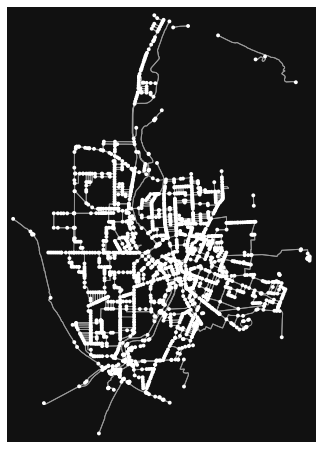

In [10]:
roc_bike_graph.plot_graph()

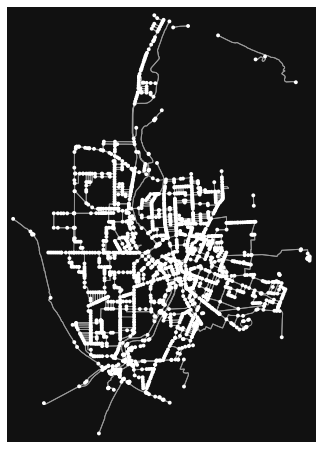

In [11]:
# add_pois not working somehow
roc_bike_graph.plot_graph(add_pois=True)